# Using a ML-like Loss Function on 2D Data

Lets try looking at the performance of different signals, with a 2D signal rather than a single dimension. Lets also use the full `haiku` infrastructure to prepare for training cuts with NN's.

In [1]:
from samples import data_2D_sig, data_2D_back
from jax_cuts import cut_erf, loss_sig_sqrt_b, cut_sigmoid, loss_x_entropy, loss_squares

import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

_ = plt.ion()

Create a complete array that has the values and the answers. The current signal and background samples aren't the same size. This just makes the loss function harder to see. So - lets create a signal sample that is as big as the background sample.

In [2]:
training_data = jnp.concatenate((data_2D_back, data_2D_sig))
training_truth = jnp.concatenate((jnp.zeros(len(data_2D_back)), jnp.ones(len(data_2D_sig))))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Loss Function Plots

This is trying to solve this by brute force - by looking at the full 2D plots for the loss function.

In [3]:
def get_min_max(data):
    data_max = max(jnp.max(data), jnp.max(data))
    data_min = min(jnp.min(data), jnp.min(data))
    lower_limit = data_min - (abs(data_min) * 0.2)
    upper_limit = data_max + (abs(data_max) * 0.2)
    return lower_limit, upper_limit


lower_x, upper_x = get_min_max(training_data[:, 0])
lower_y, upper_y = get_min_max(training_data[:, 1])

x_values = np.linspace(lower_x, upper_x, 50)
y_values = np.linspace(lower_y, upper_y, 50)

X, Y = np.meshgrid(x_values, y_values)


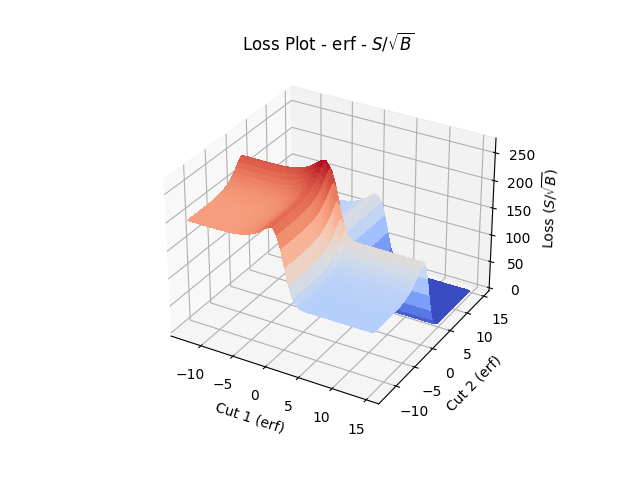

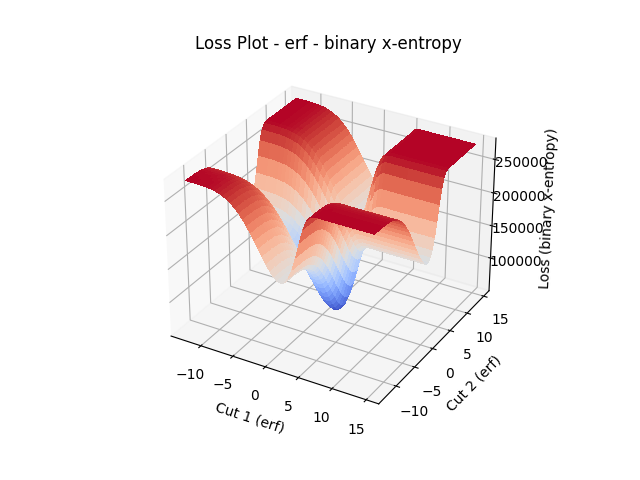

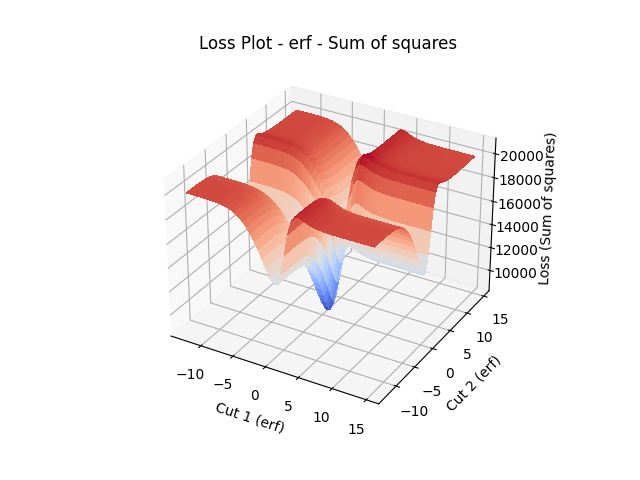

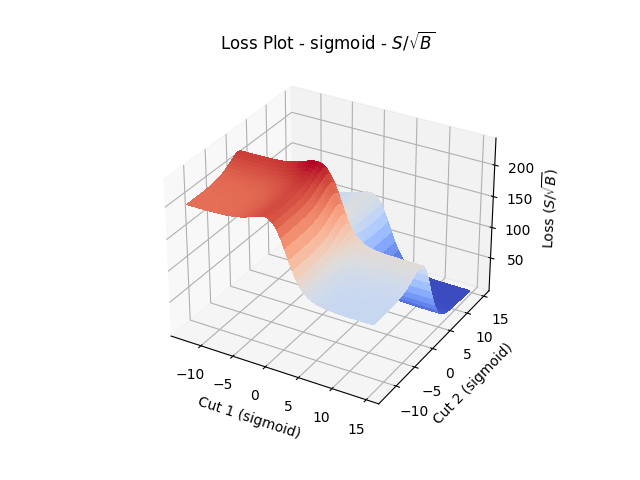

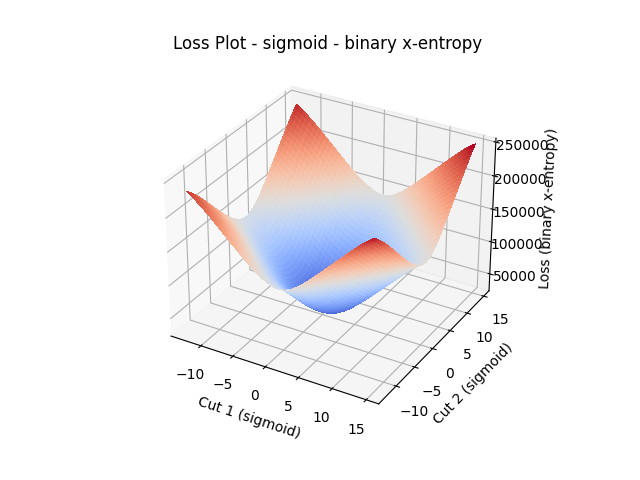

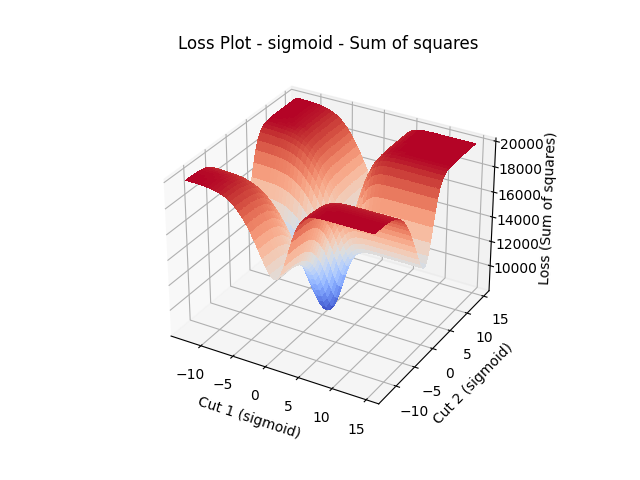

In [4]:
%matplotlib widget
import functools as ft

from jax_cuts import loss_x_entropy


def calc_loss(f_cut, f_merit, x_cut, y_cut):
    def calc_1D_loss(cut, sig, back):
        return f_merit(ft.partial(f_cut, cut), sig, back)

    return calc_1D_loss(x_cut, data_2D_sig[:, 0], data_2D_back[:, 0]) + calc_1D_loss(
        y_cut, data_2D_sig[:, 1], data_2D_back[:, 1]
    )


def plot_2D_loss(f_cut, f_cut_name, f_merit, f_merit_name):
    "Plot the 3D contour for a loss function"
    loss = np.array(
        [
            [
                calc_loss(f_cut, f_merit, X[i_x, i_y], Y[i_x, i_y])
                for i_y in range(len(y_values))
            ]
            for i_x in range(len(x_values))
        ]
    )

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(X, Y, loss, linewidth=0, antialiased=False, cmap=cm.coolwarm)
    ax.set_xlabel(f"Cut 1 ({f_cut_name})")
    ax.set_ylabel(f"Cut 2 ({f_cut_name})")
    ax.set_zlabel(f"Loss ({f_merit_name})")

    plt.title(f"Loss Plot - {f_cut_name} - {f_merit_name}")

    plt.show()


for f_cut, f_cut_name in ((cut_erf, "erf"), (cut_sigmoid, "sigmoid")):
    for f_merit, f_merit_name in (
        (loss_sig_sqrt_b, r"$S/\sqrt{B}$"),
        (loss_x_entropy, "binary x-entropy"),
        (loss_squares, "Sum of squares"),
    ):
        plot_2D_loss(f_cut, f_cut_name, f_merit, f_merit_name)


## ML Search for the best Cut Values using the Haiku Library

[Haiku](https://github.com/deepmind/dm-haiku) uses modules. We need to build the modules necessary to apply the cuts we are interested in.

The module code is stashed in the file `jax_haiku.py` file so it can be used downstream.

In [8]:
import haiku as hk
from typing import Optional, List, Callable, Dict
import jax
import optax
from optax import Params
import math

In [34]:
class Selection(hk.Module):
    """Apply a selection cut to each input, output is a weight,
    zero if the cut would reject, one if it would not"""

    def __init__(
        self,
        f_cut: Callable,
        initial_cuts: Optional[List[float]] = None,
        name="SelectionCut",
    ):
        super().__init__(name=name)
        self._initial_cuts = initial_cuts
        self._f_cut = f_cut

    def __call__(self, x):
        "Apply a selection cut for all the incoming data."

        # See if we have a decent set of initializers
        cuts_initial = (
            jnp.asarray(self._initial_cuts)
            if self._initial_cuts is not None
            else jnp.ones(x.shape[1])
        )
        assert (
            cuts_initial.shape[0] == x.shape[1]
        ), f"Incorrect number of initial cut values specified - need {x.shape[1]}"

        # Get the parameters to apply here
        cuts = hk.get_parameter(
            "cuts",
            shape=[x.shape[1]],
            dtype=jnp.float32,
            init=lambda shp, dtyp: cuts_initial,
        )

        # Next, apply the cut
        cut_data_pairing = [
            (cuts[index], x[:, index]) for index in range(0, x.shape[1])
        ]
        wts = jnp.stack([f_cut(c, x_col) for c, x_col in cut_data_pairing], axis=1)

        return jnp.prod(wts, axis=1)


And we need some sort of simple training loop to find our minimum (do not use the $S/\sqrt{B}$ loss function  as that is a maximum!).

In [9]:
def train(
    model, key, epochs, training_data, training_truth, learning_rate=0.002
) -> Dict:
    '''Run the training with the specified loss and model.

    - Simple loop with gradient feedback, one iteration per epoch
    - uses the `optax.adam` optimizer with the given learning rate.

    Args:
        model (_type_): The model to train
        key (_type_): Random number key for initalization
        epochs (_type_): How many training epochs to run
        training_data (_type_): The training data vector (signal and background)
        training_truth (_type_): A 1D vector that indicates signal or background for each training data entry.
        learning_rate (float, optional): How quickly to adjust the adam optimizer. Defaults to 0.002.

    Returns:
        Dict: The final training parameters.
    '''
    # Initialize the weights
    key, _ = jax.random.split(key)
    params = model.init(key, training_data)  # type: optax.Params

    # Init the optimizer
    opt_init, opt_update = optax.chain(optax.adam(learning_rate), optax.zero_nans())
    opt_state = opt_init(params)

    # Build the loss function
    def loss_func(weights, input_data, actual):
        "Calc the loss function"
        preds = model.apply(weights, key, input_data)
        preds = preds.squeeze()
        preds = jax.nn.sigmoid(preds)
        return optax.softmax_cross_entropy(preds, actual)

    neg_loss_func = jax.jit(jax.value_and_grad(loss_func))

    # Train
    report_interval = int(epochs / 10)
    old_params: Optional[Params] = None
    old_loss = 1000
    bad_loss = False
    for i in range(1, epochs + 1):
        loss, param_grads = neg_loss_func(params, training_data, training_truth)
        updates, opt_state = opt_update(param_grads, opt_state, params)
        params = optax.apply_updates(params, updates)

        if math.isnan(loss):
            print("WARNING: Loss is nan - returning last good epoch")
            assert (
                old_params is not None
            ), "Fatal error - did not make it a single iteration"
            params = old_params
            loss = old_loss
            bad_loss = True

        if i % report_interval == 0 or i == 1 or bad_loss:
            print(f"NegLogLoss : {loss:.2f}, epoch: {i}")

        if bad_loss:
            break

        old_params = params
        old_loss = loss

    assert params is not None
    return params  # type:ignore

In [12]:
def train_cut(f_cut: Callable, epochs=10):
    '''Simplify training a cut by setting default parameters for everything else.

    Args:
        f_cut (_type_): The Callable that can perform the cut
    '''
    def model_builder(x):
        cuts = Selection(f_cut)
        return cuts(x)
    
    model = hk.transform(model_builder)
    key = jax.random.PRNGKey(1234)

    return train(model, key, epochs, training_data, training_truth)

In [40]:
train_cut(cut_sigmoid, 5000)

NegLogLoss : 98698.24, epoch: 1
NegLogLoss : 98554.80, epoch: 500
NegLogLoss : 98512.15, epoch: 1000
NegLogLoss : 98504.36, epoch: 1500
NegLogLoss : 98503.14, epoch: 2000
NegLogLoss : 98502.99, epoch: 2500
NegLogLoss : 98502.98, epoch: 3000
NegLogLoss : 98502.98, epoch: 3500
NegLogLoss : 98502.98, epoch: 4000
NegLogLoss : 98502.98, epoch: 4500
NegLogLoss : 98502.98, epoch: 5000


{'SelectionCut': {'cuts': Array([-1.0773739, -0.3744329], dtype=float32)}}

In [41]:
# Plot the result of the above against signal and background with the lines.